In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 16/07/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = ['/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'],
         make_minitrees = False)

%matplotlib inline

In [3]:
import lax 
from lax.lichens import sciencerun1
from lax.lichens import sciencerun0
from lax.lichens import postsr1

## Pre-selection

In [4]:
# Tianyu new S2Singlescatter cut
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix=pickle.load(f)

def classify(df):
    df['CutS2SingleScatterHE'] = 0

    mask = df.eval('(largest_other_s2>0) & (s2>0) & (largest_other_s2_pattern_fit>0) \
    ')
    Y = np.concatenate([np.log10(df.loc[mask,['largest_other_s2', 'largest_other_s2_pattern_fit', 's2']]),
                    ],
                   axis=1)
    df.loc[mask,'CutS2SingleScatterHE'] = gmix.predict(Y)
    df.loc[:, 'CutS2SingleScatterHE'] = np.array(df.CutS2SingleScatterHE, bool)
    return df

CutS2Threshold = sciencerun1.S2Threshold()
CS2AFT_Extended = postsr1.CS2AreaFractionTopExtended()
CutInteractionsPeaksBiggest = sciencerun1.InteractionPeaksBiggest()
CutS2Width = sciencerun1.S2Width()
CutDAQVeto = sciencerun1.DAQVeto()
CutFlash = sciencerun1.Flash()

import sys
sys.path.insert(0, '/home/gvolta/Desktop/SR1/S1PatternLikelihoodExtended/S2PatternLikelihood')
# Chloe new S2PatternLikelihood cut
from S2PatternReducedAP import S2PatternReducedAP
from Apply_S2PatternLikelihoodCut_HE_r_phi import S2PatternLikelihood_HE

## Data BG

In [5]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
bg_path = '/project/lgrandi/ccapelli/haxcache/final_SR1/'

In [6]:
file1 = bg_path + 'bkg_SR1_pax6.10.1_p1.haxcache'
data1 = hax.minitrees.load_cache_file(file1)

data1['CutFiducialization'] = (data1['z_3d_nn_tf'] < -13.45)&(data1['z_3d_nn_tf'] > -83.45)&(data1['r_3d_nn_tf'] < 39.85)
data1 = hax.cuts.selection(data1, data1['CutFiducialization'] == True)

data1 = classify(data1)
data1 = hax.cuts.selection(data1, data1['CutS2SingleScatterHE'] == True)

data1 = CutS2Threshold.process(data1)
data1 = hax.cuts.selection(data1, data1['CutS2Threshold'] == True)

data1 = CS2AFT_Extended.process(data1)
data1 = hax.cuts.selection(data1, data1['CutCS2AreaFractionTopExtended'] == True)

data1 = CutInteractionsPeaksBiggest.process(data1)
data1 = hax.cuts.selection(data1, data1['CutInteractionPeaksBiggest'] == True)

data1 = CutS2Width.process(data1)
data1 = hax.cuts.selection(data1, data1['CutS2Width'] == True)

data1['CutS1PatternFitExist'] = np.isnan(data1['s1_pattern_fit'])
data1['CutCS2bExist'] = np.isnan(data1['cs2_bottom_nn_tf'])
data1 = hax.cuts.selection(data1, data1['CutS1PatternFitExist'] == False)
data1 = hax.cuts.selection(data1, data1['CutCS2bExist'] == False)

data1 = S2PatternLikelihood_HE(data1)
data1 = hax.cuts.selection(data1, data1['CutS2PatternLikelihoodHE'] == True)

data1 = CutDAQVeto.process(data1)
data1 = hax.cuts.selection(data1, data1['CutDAQVeto'] == True)

data1 = CutFlash.process(data1)
data1 = hax.cuts.selection(data1, data1['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 3278158 rows removed (12.18% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 353173 rows removed (22.33% passed)
Unnamed selection: 5999 rows removed (94.09% passed)
Unnamed selection: 3356 rows removed (96.49% passed)
Unnamed selection: 430 rows removed (99.53% passed)
Unnamed selection: 11984 rows removed (86.94% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1261 rows removed (98.42% passed)
Unnamed selection: 660 rows removed (99.16% passed)
Unnamed selection: 45 rows removed (99.94% passed)


In [7]:
file2 = bg_path + 'bkg_SR1_pax6.10.1_p2.haxcache'
data2 = hax.minitrees.load_cache_file(file2)

data2['CutFiducialization'] = (data2['z_3d_nn_tf'] < -13.45)&(data2['z_3d_nn_tf'] > -83.45)&(data2['r_3d_nn_tf'] < 39.85)
data2 = hax.cuts.selection(data2, data2['CutFiducialization'] == True)

data2 = classify(data2)
data2 = hax.cuts.selection(data2, data2['CutS2SingleScatterHE'] == True)

data2 = CutS2Threshold.process(data2)
data2 = hax.cuts.selection(data2, data2['CutS2Threshold'] == True)

data2 = CS2AFT_Extended.process(data2)
data2 = hax.cuts.selection(data2, data2['CutCS2AreaFractionTopExtended'] == True)

data2 = CutInteractionsPeaksBiggest.process(data2)
data2 = hax.cuts.selection(data2, data2['CutInteractionPeaksBiggest'] == True)

data2 = CutS2Width.process(data2)
data2 = hax.cuts.selection(data2, data2['CutS2Width'] == True)

data2['CutS1PatternFitExist'] = np.isnan(data2['s1_pattern_fit'])
data2['CutCS2bExist'] = np.isnan(data2['cs2_bottom_nn_tf'])
data2 = hax.cuts.selection(data2, data2['CutS1PatternFitExist'] == False)
data2 = hax.cuts.selection(data2, data2['CutCS2bExist'] == False)

data2 = S2PatternLikelihood_HE(data2)
data2 = hax.cuts.selection(data2, data2['CutS2PatternLikelihoodHE'] == True)

data2 = CutDAQVeto.process(data2)
data2 = hax.cuts.selection(data2, data2['CutDAQVeto'] == True)

data2 = CutFlash.process(data2)
data2 = hax.cuts.selection(data2, data2['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 3004154 rows removed (11.95% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 306481 rows removed (24.86% passed)
Unnamed selection: 4223 rows removed (95.84% passed)
Unnamed selection: 3538 rows removed (96.36% passed)
Unnamed selection: 358 rows removed (99.62% passed)
Unnamed selection: 10683 rows removed (88.55% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1447 rows removed (98.25% passed)
Unnamed selection: 786 rows removed (99.03% passed)
Unnamed selection: 17 rows removed (99.98% passed)


In [8]:
file3 = bg_path + 'bkg_SR1_pax6.10.1_p3.haxcache'
data3 = hax.minitrees.load_cache_file(file3)

data3['CutFiducialization'] = (data3['z_3d_nn_tf'] < -13.45)&(data3['z_3d_nn_tf'] > -83.45)&(data3['r_3d_nn_tf'] < 39.85)
data3 = hax.cuts.selection(data3, data3['CutFiducialization'] == True)

data3 = classify(data3)
data3 = hax.cuts.selection(data3, data3['CutS2SingleScatterHE'] == True)

data3 = CutS2Threshold.process(data3)
data3 = hax.cuts.selection(data3, data3['CutS2Threshold'] == True)

data3 = CS2AFT_Extended.process(data3)
data3 = hax.cuts.selection(data3, data3['CutCS2AreaFractionTopExtended'] == True)

data3 = CutInteractionsPeaksBiggest.process(data3)
data3 = hax.cuts.selection(data3, data3['CutInteractionPeaksBiggest'] == True)

data3 = CutS2Width.process(data3)
data3 = hax.cuts.selection(data3, data3['CutS2Width'] == True)

data3['CutS1PatternFitExist'] = np.isnan(data3['s1_pattern_fit'])
data3['CutCS2bExist'] = np.isnan(data3['cs2_bottom_nn_tf'])
data3 = hax.cuts.selection(data3, data3['CutS1PatternFitExist'] == False)
data3 = hax.cuts.selection(data3, data3['CutCS2bExist'] == False)

data3 = S2PatternLikelihood_HE(data3)
data3 = hax.cuts.selection(data3, data3['CutS2PatternLikelihoodHE'] == True)

data3 = CutDAQVeto.process(data3)
data3 = hax.cuts.selection(data3, data3['CutDAQVeto'] == True)

data3 = CutFlash.process(data3)
data3 = hax.cuts.selection(data3, data3['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2869656 rows removed (11.11% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 275285 rows removed (23.28% passed)
Unnamed selection: 3328 rows removed (96.02% passed)
Unnamed selection: 2703 rows removed (96.63% passed)
Unnamed selection: 309 rows removed (99.60% passed)
Unnamed selection: 9136 rows removed (88.16% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1141 rows removed (98.32% passed)
Unnamed selection: 486 rows removed (99.27% passed)
Unnamed selection: 75 rows removed (99.89% passed)


In [9]:
file4 = bg_path + 'bkg_SR1_pax6.10.1_p4.haxcache'
data4 = hax.minitrees.load_cache_file(file4)

data4['CutFiducialization'] = (data4['z_3d_nn_tf'] < -13.45)&(data4['z_3d_nn_tf'] > -83.45)&(data4['r_3d_nn_tf'] < 39.85)
data4 = hax.cuts.selection(data4, data4['CutFiducialization'] == True)

data4 = classify(data4)
data4 = hax.cuts.selection(data4, data4['CutS2SingleScatterHE'] == True)

data4 = CutS2Threshold.process(data4)
data4 = hax.cuts.selection(data4, data4['CutS2Threshold'] == True)

data4 = CS2AFT_Extended.process(data4)
data4 = hax.cuts.selection(data4, data4['CutCS2AreaFractionTopExtended'] == True)

data4 = CutInteractionsPeaksBiggest.process(data4)
data4 = hax.cuts.selection(data4, data4['CutInteractionPeaksBiggest'] == True)

data4 = CutS2Width.process(data4)
data4 = hax.cuts.selection(data4, data4['CutS2Width'] == True)

data4['CutS1PatternFitExist'] = np.isnan(data4['s1_pattern_fit'])
data4['CutCS2bExist'] = np.isnan(data4['cs2_bottom_nn_tf'])
data4 = hax.cuts.selection(data4, data4['CutS1PatternFitExist'] == False)
data4 = hax.cuts.selection(data4, data4['CutCS2bExist'] == False)

data4 = S2PatternLikelihood_HE(data4)
data4 = hax.cuts.selection(data4, data4['CutS2PatternLikelihoodHE'] == True)

data4 = CutDAQVeto.process(data4)
data4 = hax.cuts.selection(data4, data4['CutDAQVeto'] == True)

data4 = CutFlash.process(data4)
data4 = hax.cuts.selection(data4, data4['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2837268 rows removed (10.93% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 269459 rows removed (22.61% passed)
Unnamed selection: 3062 rows removed (96.11% passed)
Unnamed selection: 2482 rows removed (96.72% passed)
Unnamed selection: 262 rows removed (99.64% passed)
Unnamed selection: 9378 rows removed (87.14% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1109 rows removed (98.25% passed)
Unnamed selection: 599 rows removed (99.04% passed)
Unnamed selection: 29 rows removed (99.95% passed)


In [10]:
file5 = bg_path + 'bkg_SR1_pax6.10.1_p5.haxcache'
data5 = hax.minitrees.load_cache_file(file5)

data5['CutFiducialization'] = (data5['z_3d_nn_tf'] < -13.45)&(data5['z_3d_nn_tf'] > -83.45)&(data5['r_3d_nn_tf'] < 39.85)
data5 = hax.cuts.selection(data5, data5['CutFiducialization'] == True)

data5 = classify(data5)
data5 = hax.cuts.selection(data5, data5['CutS2SingleScatterHE'] == True)

data5 = CutS2Threshold.process(data5)
data5 = hax.cuts.selection(data5, data5['CutS2Threshold'] == True)

data5 = CS2AFT_Extended.process(data5)
data5 = hax.cuts.selection(data5, data5['CutCS2AreaFractionTopExtended'] == True)

data5 = CutInteractionsPeaksBiggest.process(data5)
data5 = hax.cuts.selection(data5, data5['CutInteractionPeaksBiggest'] == True)

data5 = CutS2Width.process(data5)
data5 = hax.cuts.selection(data5, data5['CutS2Width'] == True)

data5['CutS1PatternFitExist'] = np.isnan(data5['s1_pattern_fit'])
data5['CutCS2bExist'] = np.isnan(data5['cs2_bottom_nn_tf'])
data5 = hax.cuts.selection(data5, data5['CutS1PatternFitExist'] == False)
data5 = hax.cuts.selection(data5, data5['CutCS2bExist'] == False)

data5 = S2PatternLikelihood_HE(data5)
data5 = hax.cuts.selection(data5, data5['CutS2PatternLikelihoodHE'] == True)

data5 = CutDAQVeto.process(data5)
data5 = hax.cuts.selection(data5, data5['CutDAQVeto'] == True)

data5 = CutFlash.process(data5)
data5 = hax.cuts.selection(data5, data5['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2854580 rows removed (10.90% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 270124 rows removed (22.68% passed)
Unnamed selection: 2977 rows removed (96.24% passed)
Unnamed selection: 2592 rows removed (96.60% passed)
Unnamed selection: 305 rows removed (99.59% passed)
Unnamed selection: 9293 rows removed (87.33% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1168 rows removed (98.18% passed)
Unnamed selection: 598 rows removed (99.05% passed)
Unnamed selection: 82 rows removed (99.87% passed)


In [11]:
file6 = bg_path + 'bkg_SR1_pax6.10.1_p6.haxcache'
data6 = hax.minitrees.load_cache_file(file6)

data6['CutFiducialization'] = (data6['z_3d_nn_tf'] < -13.45)&(data6['z_3d_nn_tf'] > -83.45)&(data6['r_3d_nn_tf'] < 39.85)
data6 = hax.cuts.selection(data6, data6['CutFiducialization'] == True)

data6 = classify(data6)
data6 = hax.cuts.selection(data6, data6['CutS2SingleScatterHE'] == True)

data6 = CutS2Threshold.process(data6)
data6 = hax.cuts.selection(data6, data6['CutS2Threshold'] == True)

data6 = CS2AFT_Extended.process(data6)
data6 = hax.cuts.selection(data6, data6['CutCS2AreaFractionTopExtended'] == True)

data6 = CutInteractionsPeaksBiggest.process(data6)
data6 = hax.cuts.selection(data6, data6['CutInteractionPeaksBiggest'] == True)

data6 = CutS2Width.process(data6)
data6 = hax.cuts.selection(data6, data6['CutS2Width'] == True)

data6['CutS1PatternFitExist'] = np.isnan(data6['s1_pattern_fit'])
data6['CutCS2bExist'] = np.isnan(data6['cs2_bottom_nn_tf'])
data6 = hax.cuts.selection(data6, data6['CutS1PatternFitExist'] == False)
data6 = hax.cuts.selection(data6, data6['CutCS2bExist'] == False)

data6 = S2PatternLikelihood_HE(data6)
data6 = hax.cuts.selection(data6, data6['CutS2PatternLikelihoodHE'] == True)

data6 = CutDAQVeto.process(data6)
data6 = hax.cuts.selection(data6, data6['CutDAQVeto'] == True)

data6 = CutFlash.process(data6)
data6 = hax.cuts.selection(data6, data6['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2833343 rows removed (10.92% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 267512 rows removed (22.94% passed)
Unnamed selection: 2811 rows removed (96.47% passed)
Unnamed selection: 2540 rows removed (96.69% passed)
Unnamed selection: 341 rows removed (99.54% passed)
Unnamed selection: 9390 rows removed (87.30% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1178 rows removed (98.18% passed)
Unnamed selection: 511 rows removed (99.19% passed)
Unnamed selection: 85 rows removed (99.86% passed)


In [12]:
file7 = bg_path + 'bkg_SR1_pax6.10.1_p7.haxcache'
data7 = hax.minitrees.load_cache_file(file7)

data7['CutFiducialization'] = (data7['z_3d_nn_tf'] < -13.45)&(data7['z_3d_nn_tf'] > -83.45)&(data7['r_3d_nn_tf'] < 39.85)
data7 = hax.cuts.selection(data7, data7['CutFiducialization'] == True)

data7 = classify(data7)
data7 = hax.cuts.selection(data7, data7['CutS2SingleScatterHE'] == True)

data7 = CutS2Threshold.process(data7)
data7 = hax.cuts.selection(data7, data7['CutS2Threshold'] == True)

data7 = CS2AFT_Extended.process(data7)
data7 = hax.cuts.selection(data7, data7['CutCS2AreaFractionTopExtended'] == True)

data7 = CutInteractionsPeaksBiggest.process(data7)
data7 = hax.cuts.selection(data7, data7['CutInteractionPeaksBiggest'] == True)

data7 = CutS2Width.process(data7)
data7 = hax.cuts.selection(data7, data7['CutS2Width'] == True)

data7['CutS1PatternFitExist'] = np.isnan(data7['s1_pattern_fit'])
data7['CutCS2bExist'] = np.isnan(data7['cs2_bottom_nn_tf'])
data7 = hax.cuts.selection(data7, data7['CutS1PatternFitExist'] == False)
data7 = hax.cuts.selection(data7, data7['CutCS2bExist'] == False)

data7 = S2PatternLikelihood_HE(data7)
data7 = hax.cuts.selection(data7, data7['CutS2PatternLikelihoodHE'] == True)

data7 = CutDAQVeto.process(data7)
data7 = hax.cuts.selection(data7, data7['CutDAQVeto'] == True)

data7 = CutFlash.process(data7)
data7 = hax.cuts.selection(data7, data7['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2752938 rows removed (10.68% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 253617 rows removed (22.99% passed)
Unnamed selection: 2628 rows removed (96.53% passed)
Unnamed selection: 2283 rows removed (96.88% passed)
Unnamed selection: 256 rows removed (99.64% passed)
Unnamed selection: 8851 rows removed (87.45% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 1302 rows removed (97.89% passed)
Unnamed selection: 460 rows removed (99.24% passed)
Unnamed selection: 86 rows removed (99.86% passed)


In [14]:
file9 = bg_path + 'bkg_SR1_pax6.10.1_p9.haxcache'
data9 = hax.minitrees.load_cache_file(file9)

data9['CutFiducialization'] = (data9['z_3d_nn_tf'] < -13.45)&(data9['z_3d_nn_tf'] > -93.45)&(data9['r_3d_nn_tf'] < 39.95)
data9 = hax.cuts.selection(data9, data9['CutFiducialization'] == True)

data9 = classify(data9)
data9 = hax.cuts.selection(data9, data9['CutS2SingleScatterHE'] == True)

data9 = CutS2Threshold.process(data9)
data9 = hax.cuts.selection(data9, data9['CutS2Threshold'] == True)

data9 = CS2AFT_Extended.process(data9)
data9 = hax.cuts.selection(data9, data9['CutCS2AreaFractionTopExtended'] == True)

data9 = CutInteractionsPeaksBiggest.process(data9)
data9 = hax.cuts.selection(data9, data9['CutInteractionPeaksBiggest'] == True)

data9 = CutS2Width.process(data9)
data9 = hax.cuts.selection(data9, data9['CutS2Width'] == True)

data9['CutS1PatternFitExist'] = np.isnan(data9['s1_pattern_fit'])
data9['CutCS2bExist'] = np.isnan(data9['cs2_bottom_nn_tf'])
data9 = hax.cuts.selection(data9, data9['CutS1PatternFitExist'] == False)
data9 = hax.cuts.selection(data9, data9['CutCS2bExist'] == False)

data9 = S2PatternLikelihood_HE(data9)
data9 = hax.cuts.selection(data9, data9['CutS2PatternLikelihoodHE'] == True)

data9 = CutDAQVeto.process(data9)
data9 = hax.cuts.selection(data9, data9['CutDAQVeto'] == True)

data9 = CutFlash.process(data9)
data9 = hax.cuts.selection(data9, data9['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2666976 rows removed (12.54% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 285942 rows removed (25.25% passed)
Unnamed selection: 2785 rows removed (97.12% passed)
Unnamed selection: 3274 rows removed (96.51% passed)
Unnamed selection: 334 rows removed (99.63% passed)
Unnamed selection: 13446 rows removed (85.09% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 2364 rows removed (96.92% passed)
Unnamed selection: 743 rows removed (99.00% passed)
Unnamed selection: 106 rows removed (99.86% passed)


In [15]:
file10 = bg_path + 'bkg_SR1_pax6.10.1_p10.haxcache'
data10 = hax.minitrees.load_cache_file(file10)

data10['CutFiducialization'] = (data10['z_3d_nn_tf'] < -13.45)&(data10['z_3d_nn_tf'] > -103.45)&(data10['r_3d_nn_tf'] < 39.105)
data10 = hax.cuts.selection(data10, data10['CutFiducialization'] == True)

data10 = classify(data10)
data10 = hax.cuts.selection(data10, data10['CutS2SingleScatterHE'] == True)

data10 = CutS2Threshold.process(data10)
data10 = hax.cuts.selection(data10, data10['CutS2Threshold'] == True)

data10 = CS2AFT_Extended.process(data10)
data10 = hax.cuts.selection(data10, data10['CutCS2AreaFractionTopExtended'] == True)

data10 = CutInteractionsPeaksBiggest.process(data10)
data10 = hax.cuts.selection(data10, data10['CutInteractionPeaksBiggest'] == True)

data10 = CutS2Width.process(data10)
data10 = hax.cuts.selection(data10, data10['CutS2Width'] == True)

data10['CutS1PatternFitExist'] = np.isnan(data10['s1_pattern_fit'])
data10['CutCS2bExist'] = np.isnan(data10['cs2_bottom_nn_tf'])
data10 = hax.cuts.selection(data10, data10['CutS1PatternFitExist'] == False)
data10 = hax.cuts.selection(data10, data10['CutCS2bExist'] == False)

data10 = S2PatternLikelihood_HE(data10)
data10 = hax.cuts.selection(data10, data10['CutS2PatternLikelihoodHE'] == True)

data10 = CutDAQVeto.process(data10)
data10 = hax.cuts.selection(data10, data10['CutDAQVeto'] == True)

data10 = CutFlash.process(data10)
data10 = hax.cuts.selection(data10, data10['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2626905 rows removed (12.97% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 276115 rows removed (29.47% passed)
Unnamed selection: 2872 rows removed (97.51% passed)
Unnamed selection: 2599 rows removed (97.69% passed)
Unnamed selection: 374 rows removed (99.66% passed)
Unnamed selection: 16812 rows removed (84.65% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 3142 rows removed (96.61% passed)
Unnamed selection: 507 rows removed (99.43% passed)
Unnamed selection: 105 rows removed (99.88% passed)


In [18]:
file11 = bg_path + 'bkg_SR1_pax6.10.1_p11.haxcache'
data11 = hax.minitrees.load_cache_file(file11)

data11['CutFiducialization'] = (data11['z_3d_nn_tf'] < -13.45)&(data11['z_3d_nn_tf'] > -113.45)&(data11['r_3d_nn_tf'] < 39.115)
data11 = hax.cuts.selection(data11, data11['CutFiducialization'] == True)

data11 = classify(data11)
data11 = hax.cuts.selection(data11, data11['CutS2SingleScatterHE'] == True)

data11 = CutS2Threshold.process(data11)
data11 = hax.cuts.selection(data11, data11['CutS2Threshold'] == True)

data11 = CS2AFT_Extended.process(data11)
data11 = hax.cuts.selection(data11, data11['CutCS2AreaFractionTopExtended'] == True)

data11 = CutInteractionsPeaksBiggest.process(data11)
data11 = hax.cuts.selection(data11, data11['CutInteractionPeaksBiggest'] == True)

data11 = CutS2Width.process(data11)
data11 = hax.cuts.selection(data11, data11['CutS2Width'] == True)

data11['CutS1PatternFitExist'] = np.isnan(data11['s1_pattern_fit'])
data11['CutCS2bExist'] = np.isnan(data11['cs2_bottom_nn_tf'])
data11 = hax.cuts.selection(data11, data11['CutS1PatternFitExist'] == False)
data11 = hax.cuts.selection(data11, data11['CutCS2bExist'] == False)

data11 = S2PatternLikelihood_HE(data11)
data11 = hax.cuts.selection(data11, data11['CutS2PatternLikelihoodHE'] == True)

data11 = CutDAQVeto.process(data11)
data11 = hax.cuts.selection(data11, data11['CutDAQVeto'] == True)

data11 = CutFlash.process(data11)
data11 = hax.cuts.selection(data11, data11['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2636332 rows removed (13.04% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 278597 rows removed (29.52% passed)
Unnamed selection: 2984 rows removed (97.44% passed)
Unnamed selection: 2794 rows removed (97.54% passed)
Unnamed selection: 361 rows removed (99.67% passed)
Unnamed selection: 17385 rows removed (84.27% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 3454 rows removed (96.29% passed)
Unnamed selection: 1155 rows removed (98.71% passed)
Unnamed selection: 115 rows removed (99.87% passed)


In [19]:
data = [data1, data2, data3, data4, data5, data6, data7, data9, data10, data11]
data = pd.concat(data, ignore_index=True)
del data1, data2, data3, data4, data5, data6, data7, data9, data10, data11

### Some plots

In [20]:
W = 13.7 #eV
g1 = 0.1432 + 0.000049*data['z_3d_nn']
g2 = 11.63  + 0.009*data['z_3d_nn']

data['CES'] = W*((data['cs1']/g1) + (data['cs2_bottom']/g2) )

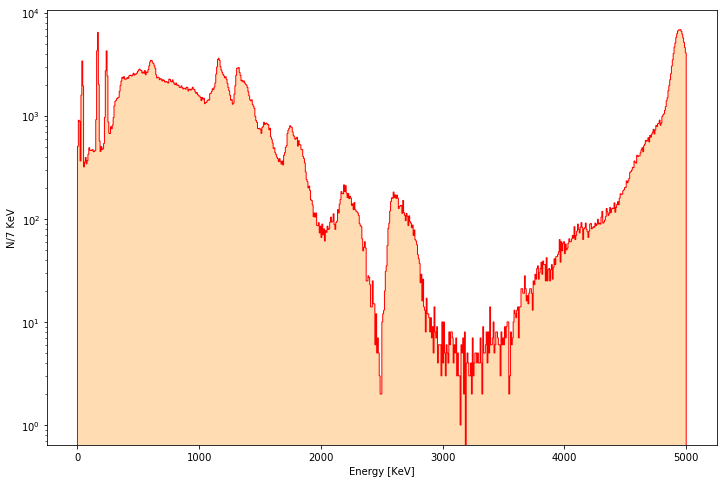

In [21]:
plt.figure(figsize=(12,8))
plt.hist(data['CES']/10**3, bins = (700), 
         range=(0, 5000), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(data['CES']/10**3, bins = (700), 
         range=(0, 5000), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [KeV]')
plt.ylabel('N/7 KeV')
plt.yscale('log')

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


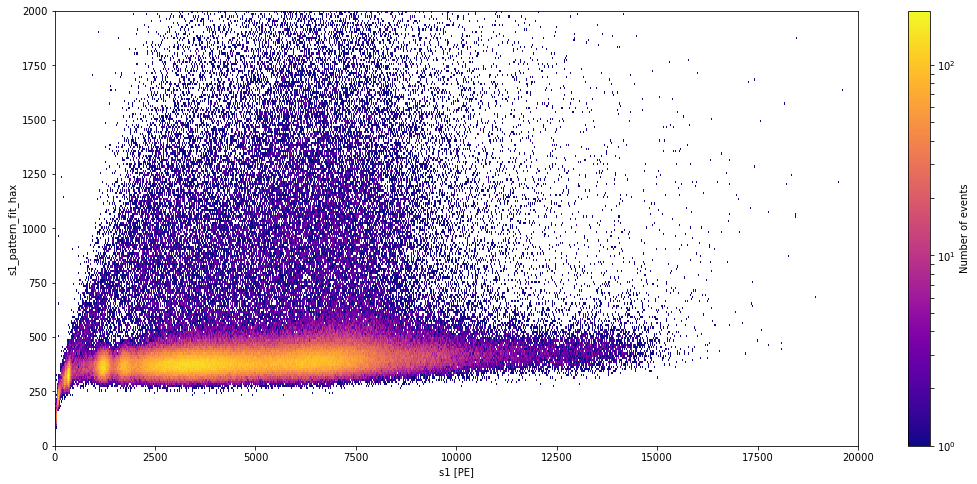

In [24]:
plt.figure(figsize=(18,8))
plt.hist2d(data['cs1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
           range=((0,2e4), (0,2000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

In [25]:
data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/BG_SR1_S1PL.pkl')